In [11]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import shapiro

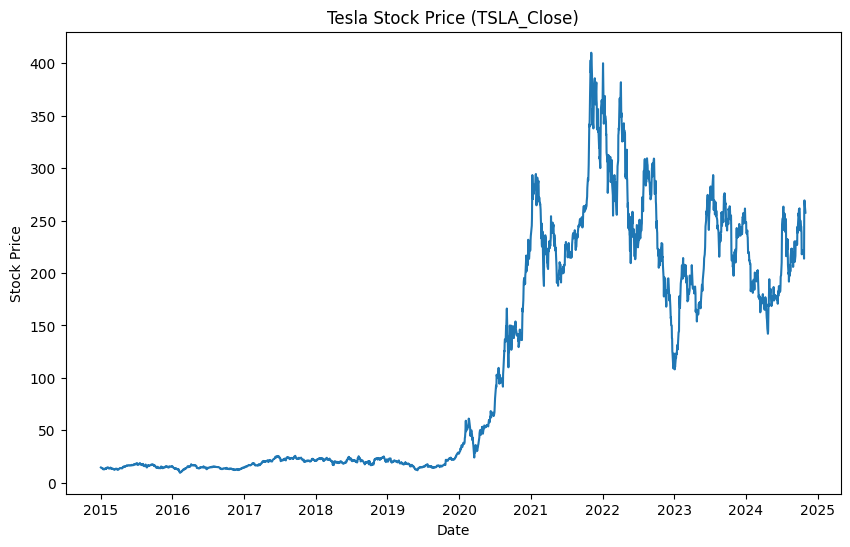

Training set shape: (1979,), Test set shape: (495,)


In [12]:
# Load cleaned data
df = pd.read_csv('tesla_bnd_spy_cleaned_data_with_columns.csv', index_col='Date', parse_dates=True)

# Extract Tesla's stock price data (TSLA_Close)
tesla_data = df['TSLA_Close']

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(tesla_data)
plt.title('Tesla Stock Price (TSLA_Close)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

# Split the data into training and testing sets
train_size = int(len(tesla_data) * 0.8)  # 80% training, 20% testing
train, test = tesla_data[:train_size], tesla_data[train_size:]

# Display the shapes of the training and test sets
print(f"Training set shape: {train.shape}, Test set shape: {test.shape}")

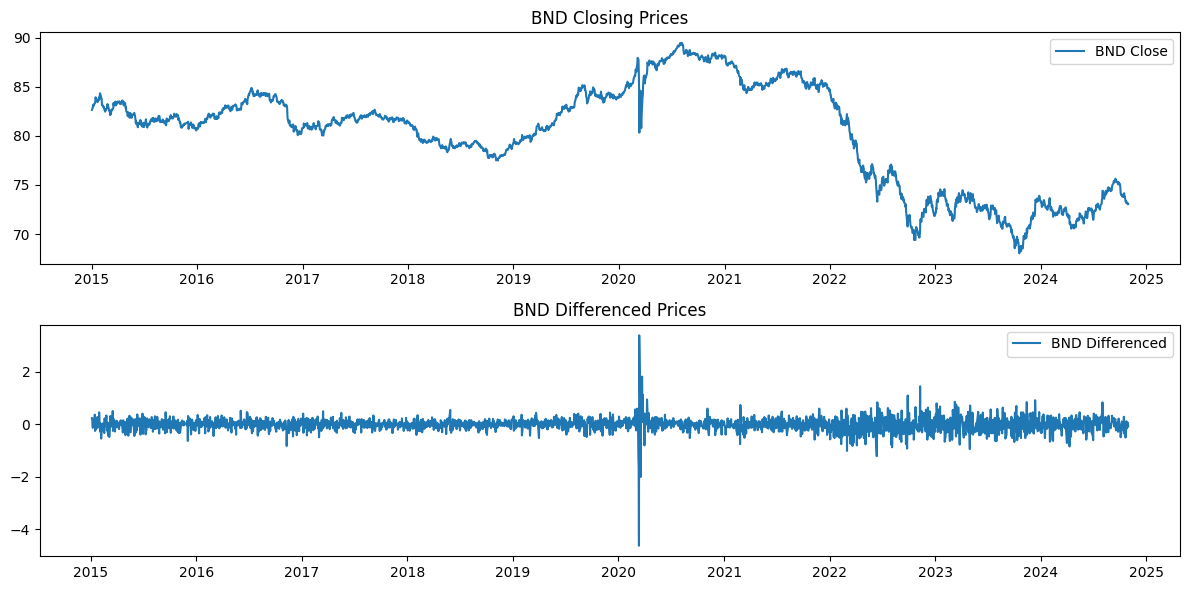

In [13]:
# Step 1: Visualize the Data
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(df['BND_Close'], label='BND Close')
plt.title('BND Closing Prices')
plt.legend()

# Step 2: Visualize the Differenced Series
plt.subplot(212)
plt.plot(df['BND_Close'].diff().dropna(), label='BND Differenced')
plt.title('BND Differenced Prices')
plt.legend()

plt.tight_layout()
plt.show()

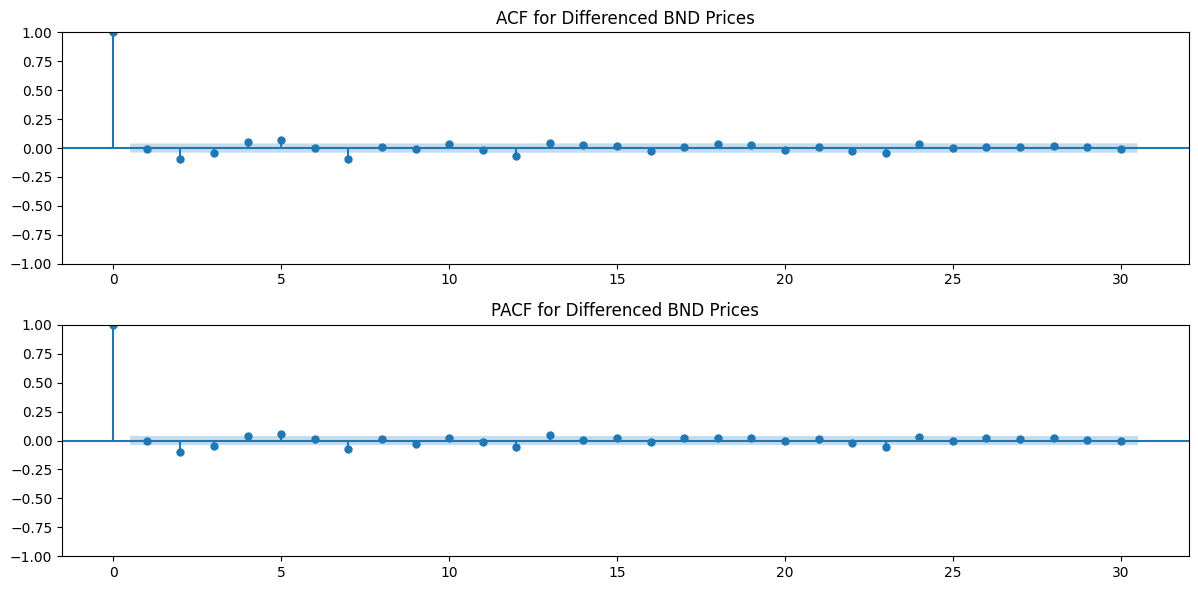

In [14]:
# Step 3: ACF and PACF plots for differenced series
plt.figure(figsize=(12, 6))

# Plot ACF
plt.subplot(211)
plot_acf(df['BND_Close'].diff().dropna(), lags=30, ax=plt.gca())
plt.title('ACF for Differenced BND Prices')

# Plot PACF
plt.subplot(212)
plot_pacf(df['BND_Close'].diff().dropna(), lags=30, ax=plt.gca())
plt.title('PACF for Differenced BND Prices')

plt.tight_layout()
plt.show()

The index is already a datetime index.


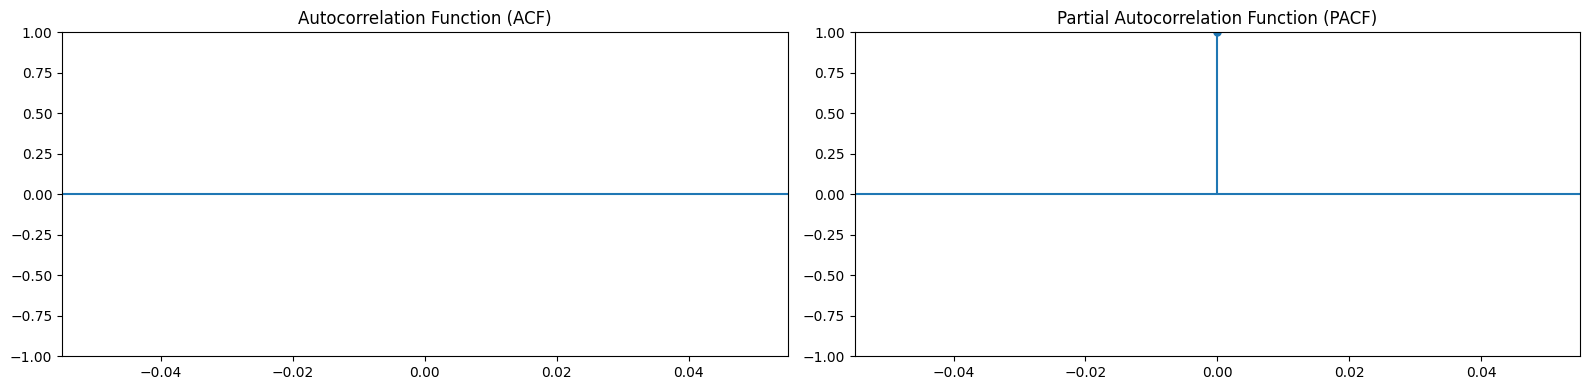

                               SARIMAX Results                                
Dep. Variable:              BND_Close   No. Observations:                 2564
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -300.362
Date:                Sun, 17 Nov 2024   AIC                            606.724
Time:                        18:26:00   BIC                            624.270
Sample:                    01-02-2015   HQIC                           613.086
                         - 10-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5864      0.079      7.452      0.000       0.432       0.741
ma.L1         -0.6371      0.077     -8.247      0.000      -0.788      -0.486
sigma2         0.0729      0.000    172.371      0.0

In [15]:
import statsmodels.api as sm 

# Step 5: Forecasting the Next 10 Days

if 'Date' in df.columns:
    
    df['Date'] = pd.to_datetime(df['Date'])
    
    df.set_index('Date', inplace=True)

if isinstance(df.index, pd.DatetimeIndex):
    print("The index is already a datetime index.")

df = df.asfreq('B')  

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(df['BND_Close'], ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(df['BND_Close'], ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# Fit the ARIMA model (adjust p, d, q as per the ACF/PACF analysis)
model = sm.tsa.ARIMA(df['BND_Close'], order=(1, 1, 1))  # Example: ARIMA(1, 1, 1)
model_fit = model.fit()

# Print model summary to check coefficients, p-values, AIC, BIC, etc.
print(model_fit.summary())

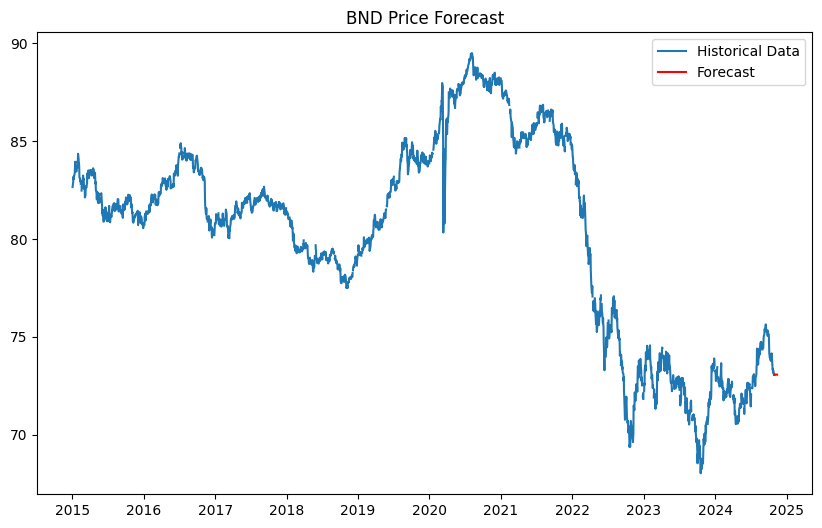

In [16]:
# Step 6: Visualize the Forecast

forecast_steps = 10  

# Forecast the next `forecast_steps` steps
forecast = model_fit.forecast(steps=forecast_steps)

# Plot the historical data and forecasted data
plt.figure(figsize=(10, 6))
plt.plot(df['BND_Close'], label='Historical Data')  # Plot the historical data
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps + 1, freq='B')[1:], forecast, label='Forecast', color='red')  # Plot the forecast
plt.title('BND Price Forecast')
plt.legend()
plt.show()

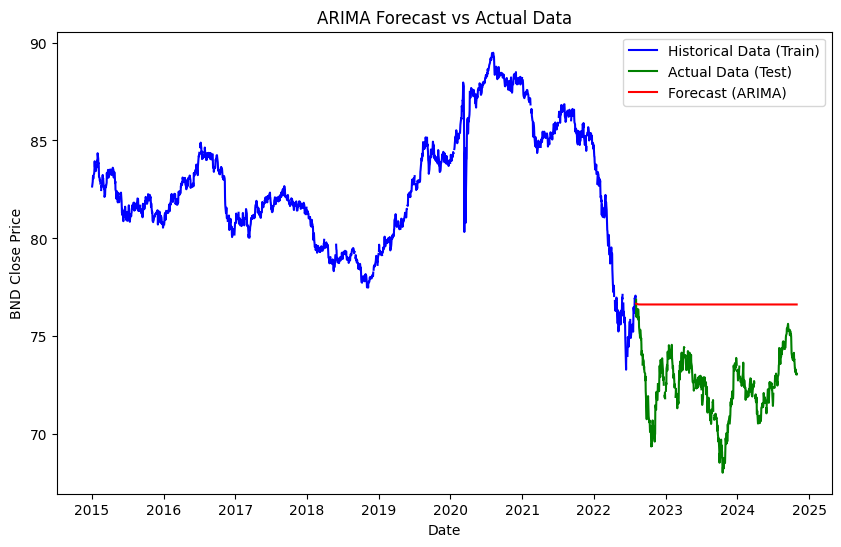

Forecasted values:  2022-08-04 00:00:00+00:00    76.667400
2022-08-05 00:00:00+00:00    76.657882
2022-08-08 00:00:00+00:00    76.650692
2022-08-09 00:00:00+00:00    76.645261
2022-08-10 00:00:00+00:00    76.641159
                               ...    
2024-10-24 00:00:00+00:00    76.628492
2024-10-25 00:00:00+00:00    76.628492
2024-10-28 00:00:00+00:00    76.628492
2024-10-29 00:00:00+00:00    76.628492
2024-10-30 00:00:00+00:00    76.628492
Freq: B, Name: predicted_mean, Length: 585, dtype: float64


In [17]:
# Step 7: Evaluate Model Performance 
# Split the data into training and testing
train_data = df['BND_Close'][:1979]  
test_data = df['BND_Close'][1979:]   

# Train the ARIMA model on the training data
model = ARIMA(train_data, order=(1, 1, 1))  
model_fit = model.fit()

# Forecast the next 495 steps (for the test set)
forecast_steps = len(test_data)
forecast_values = model_fit.forecast(steps=forecast_steps)

# Create a figure to plot the results
plt.figure(figsize=(10, 6))

# Plot the historical (training) data
plt.plot(train_data, label='Historical Data (Train)', color='blue')

# Plot the actual test data (what you're trying to predict)
plt.plot(test_data.index, test_data, label='Actual Data (Test)', color='green')

# Plot the forecasted data (ARIMA predictions)
plt.plot(test_data.index, forecast_values, label='Forecast (ARIMA)', color='red')

plt.title('ARIMA Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('BND Close Price')
plt.legend()
plt.show()

# Print out forecast values for further evaluation
print("Forecasted values: ", forecast_values)

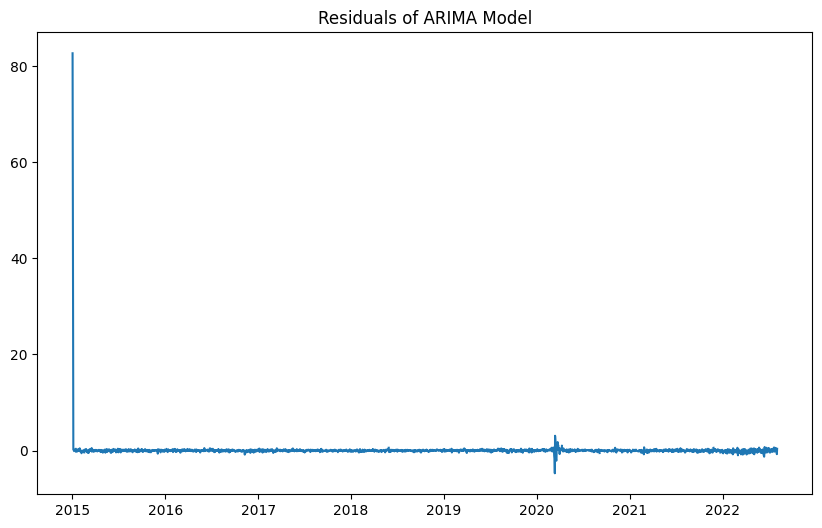

<Figure size 1200x600 with 0 Axes>

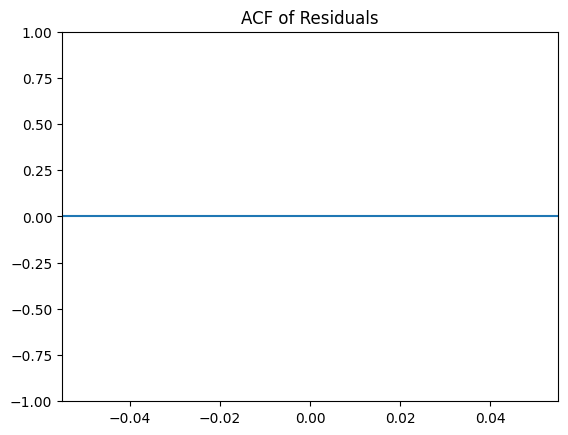

Shapiro-Wilk Test p-value: nan
Residuals are not normally distributed.


In [18]:
# Step 8: Residual Diagnostics
# Residuals analysis
residuals = model_fit.resid

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.show()

# ACF plot of residuals to check for autocorrelation
plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=30)
plt.title('ACF of Residuals')
plt.show()

# Normality Test (Shapiro-Wilk Test)
stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk Test p-value: {p_value}")

# If p-value > 0.05, residuals are normally distributed
if p_value > 0.05:
    print("Residuals are normally distributed.")
else:
    print("Residuals are not normally distributed.")

In [21]:

if np.isnan(test_data).any() or np.isnan(forecast_values).any():
    valid_indices = ~np.isnan(test_data) & ~np.isnan(forecast_values)
    test_data = test_data[valid_indices]
    forecast_values = forecast_values[valid_indices]

# Ensure forecast_values and test_data have the same length
if len(test_data) != len(forecast_values):
    forecast_values = forecast_values[:len(test_data)]

# Now calculate the error metrics
mae = mean_absolute_error(test_data, forecast_values)
mse = mean_squared_error(test_data, forecast_values)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)


MAE: 4.148729373787311
MSE: 19.745440508365476
RMSE: 4.443584196160288
